<b>Use Gemini to prompt Stable Diffusion</b>

Finding the right words to prompt an image generator can be a chore. Use Google's latest model release, Gemini, to prompt Stable Diffusion to produce amazing generated imagery.

This notebook includes modified code from [woctezuma/stable-diffusion-colab](https://github.com/woctezuma/stable-diffusion-colab). Thanks.

In [1]:
#@title Check for a GPU
#todo fail if this fails

import os

if os.system('nvidia-smi'):
  raise Exception("No GPU found. Access a GPU through Runtime > Change runtime type and try again.")

In [3]:
#@title Configure Gemini API key

#Access your Gemini API key

import google.generativeai as genai
from google.colab import userdata

gemini_api_secret_name = 'as'  # @param {type: "string"}

try:
  GOOGLE_API_KEY=userdata.get(gemini_api_secret_name)
  genai.configure(api_key=GOOGLE_API_KEY)
except userdata.SecretNotFoundError as e:
   print(f'''Secret not found\n\nThis expects you to create a secret named {gemini_api_secret_name} in Colab\n\nVisit https://makersuite.google.com/app/apikey to create an API key\n\nStore that in the secrets section on the left side of the notebook (key icon)\n\nName the secret {gemini_api_secret_name}''')
   raise e
except userdata.NotebookAccessError as e:
  print(f'''You need to grant this notebook access to the {gemini_api_secret_name} secret in order for the notebook to access Gemini on your behalf.''')
  raise e
except Exception as e:
  # unknown error
  print(f"There was an unknown error. Ensure you have a secret {gemini_api_secret_name} stored in Colab and it's a valid key from https://makersuite.google.com/app/apikey")
  raise e

model = genai.GenerativeModel('gemini-pro')

In [4]:
#@title Setup dependencies & pipeline - this takes a bit

%pip install --quiet --upgrade diffusers accelerate mediapy

import mediapy as media, random, sys, torch
from diffusers import AutoPipelineForText2Image

pipe = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/sdxl-turbo",
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
    )

pipe = pipe.to("cuda")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.4 MB/s eta 0:00:00


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.78k [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

tokenizer_2/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
#@title Use Gemini to create a text prompt with to feed to Stable Diffusion

model = genai.GenerativeModel('gemini-pro')

text = 'Draw a kitty cat typing on a computer' # @param {type:"string"}

prompt = "You are creating a prompt for Stable Diffusion to generate an image. Please generate a text prompt for %s. Only respond with the prompt itself, but embellish it as needed but keep it under 80 tokens." % text
response = model.generate_content(prompt)
response.text

'Golden rays of sunlight spilling into a cozy nook illuminating a tabby cat sitting upright, typing with nimble paws on a vintage typewriter, surrounded by stacks of manuscripts, an intrigued expression on its face, determined to craft its literary masterpiece'

  0%|          | 0/20 [00:00<?, ?it/s]

""

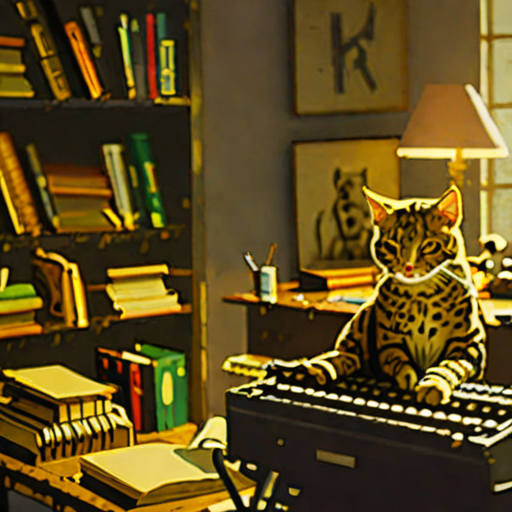

In [6]:
#@title Generate the image with Stable Diffusion

prompt = response.text
seed = random.randint(0, sys.maxsize)

num_inference_steps = 20

images = pipe(
    prompt = prompt,
    guidance_scale = 0.0,
    num_inference_steps = num_inference_steps,
    generator = torch.Generator("cuda").manual_seed(seed),
    ).images

media.show_images(images)